

## **1. Accessing and Reading the Kaggle Data Sets**

The competition data is separated into training and test sets. Each record includes the property values of the house and attributes such as street type, year of construction, roof type, basement condition.

The data includes multiple data types, including integers (year of construction), discrete labels (roof type), floating point numbers, etc.; Some data is missing and is thus labeled 'na'.

The price of each house, namely the label, is only included in the training data set (it is a competition after all). The 'Data' tab on the competition tab has links to download the data.

We will read and process the data using `pandas`, an [efficient data analysis toolkit](http://pandas.pydata.org/pandas-docs/stable/). It is already part of colab.

In [1]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

import matplotlib.pyplot as plt
import os
import importlib
import time
import math
import random

import numpy as np
import torch
import pandas as pd

import torch
import torchvision
from torch import nn
from torch.utils import data
from torchvision import transforms

Below allows anyone to access and train the data in the notebook without having to configure the data sets

In [6]:
def install_package(package):
    try:
        importlib.import_module(package)
    except ImportError:
        import sys
        !{sys.executable} -m pip install {package}

def is_running_in_colab():
    try:
        from google.colab import _ipython as ip
        return True
    except ImportError:
        return False

try:
  if is_running_in_colab():
    print("Running in Google Colab")
  else:
    print("Running in Jupyter or VSCode")

  import requests
  url = 'https://raw.githubusercontent.com/joccing/ICT303-assignment1/master/config.py'
  r = requests.get(url, allow_redirects=True)
  open('config.py', 'wb').write(r.content)

except ModuleNotFoundError:
  pass

from config import *
config_data()

Running in Google Colab
Finished!


In [7]:
try:
    import pandas as pd
except ImportError:
    # If pandas is not installed, install it
    install_package('pandas')
    import pandas as pd

train_data = pd.read_csv('data/train.csv')
test_data  = pd.read_csv('data/test.csv')
assert train_data.shape == (1460,81)
assert test_data.shape == (1459, 80)
print('Loaded and verified data!')

Loaded and verified data!


Checking the content of the files

In [8]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Let’s take a look at the first 4 and last 2 features as well as the label (SalePrice) from the first 4 examples:

In [5]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


We can see that in each example, the first feature is the ID. This helps the model identify each training example. While this is convenient, it doesn't carry any information for prediction purposes. Hence we remove it from the dataset before feeding the data into the network.

In [9]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## **2. Data Preprocessing**

As stated above, we have a wide variety of datatypes. Before we feed it into a  network we need to perform some amount of processing.

Let's start with the **numerical features**. We begin by replacing missing values with the mean. This is a reasonable strategy if features are missing at random. To adjust them to a common scale we rescale them to zero mean and unit variance. This is accomplished as follows:

$$x \leftarrow \frac{x - \mu}{\sigma}.$$

This process is called **normalization** or **standardisation**. The reason for normalizing the data is that it brings all features to the same order of magnitude. After all, we do not know *a priori* which features are likely to be relevant. Hence it makes sense to treat them equally.

Below the code that does the normalization for each numerical features:

In [10]:
# Normalize the numerical features
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# Apply standardization
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

# Set missing values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features.shape

(2919, 79)

Data after normalizing numeric features

In [8]:
all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,MSSubClass,MSZoning,LotFrontage,LotArea,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,-1.363335,WD,Abnorml


Next we deal with the **discrete values**. This includes variables such as 'MSZoning'. We replace them by a one-hot encoding in the same manner as how we transformed multiclass classification data into a vector of $0$ and $1$. For instance, 'MSZoning' assumes the values 'RL' and 'RM'. They map into vectors $(1,0)$ and $(0,1)$ respectively. Pandas does this automatically for us.

In [11]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and creates an indicative feature for it.
all_features = pd.get_dummies(all_features, dummy_na=True)
print(f'Shape of all training data: {all_features.shape}')
print(f'Shape of non-processed training: {train_data.shape}')
print(f'Shape of non-processed test: {test_data.shape}')

Shape of all training data: (2919, 331)
Shape of non-processed training: (1460, 81)
Shape of non-processed test: (1459, 80)


You can see that this conversion increases the number of features from 79 to 331.

Finally, via the `values` attribute we can extract the NumPy format from the Pandas dataframe and prepare them for training.

In [12]:
n_train = train_data.shape[0]

# the train feature are in all_features[:n_train].values
train_features =  torch.tensor(all_features[:n_train].values, dtype=torch.float32)

# the test feature are in all_features[n_train:].values
test_features  = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

# the train labels are in train_data.SalePrice.values
train_labels   = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## **3. Training**

### **3.1. Loss function**
The loss function below uses Mean Square Error(MSE). MSE is the average of the squared differences between the predictions and the targets. MSE is chosen over other loss function (Mean Absolute Error (MAE), Huber loss, etc.) as there is no concern over outliers in the data and the errors are heteroscedastic (residual errors are not constant across independent variables).

The activation function ReLU is chosen because it tends to work well in practice and helps to alleviate the vanishing gradients problem, which is when gradients are passed back through the network and become progressively smaller and less useful for learning.

The model is a simple single-layer feed-forward network with a linear layer and 1 hidden layer. It is by definition, an MLP (multi-layer perceptrons) network. More explanations are provided below.

In [22]:
loss = nn.MSELoss()

n_inputs = train_features.shape[1]

def get_net():
    net = nn.Sequential(
        nn.Linear(n_inputs, 64),  # Input layer to hidden layer
        nn.ReLU(),                # Activation function
        nn.Linear(64, 1)          # Hidden layer to output layer
    )
    return net

With the logarithm of the predictions and actuals, the proportional differences are considered instead of the absolute differences. This means, it can deal better with cases where the target variable has a wide range and prevent the model from giving too much weight to the deviations of large values.

The model is trained for a regression task, where the prediction is a continuous value as opposed to a discrete class label.

In [23]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [24]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

The below train function takes in the neural network, the training and testing features and labels, the number of epochs to train for, the learning rate, weight decay (regularization parameter) and batch size. It optimizes the network parameters for the given number of epochs using the Adam optimizer.  The Adam optimizer updates network weights iteratively based on training data. Here, for each epoch, it calculates the loss, does back propagation and updates the weights.

Adam is chosen because it combines the best properties of the AdaGrad and RMSProp optimization algorithms, which allows it to handle sparse gradients on noisy problems.

In [25]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):

    train_ls, test_ls = [], []

    train_iter = load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()

        train_l = log_rmse(net, train_features, train_labels)     #training loss after the current epoch
        train_ls.append(train_l)
        #print(f'Epoch: ', epoch, ' Training Loss: ', train_l)
        if test_labels is not None:
            test_l = log_rmse(net, test_features, test_labels)    #test loss after the current epoch
            test_ls.append(test_l)

    return train_ls, test_ls

### **3.2. k-Fold Cross-Validation**

This model uses a simple multi-layer perceptrons (MLP), with the number of inputs equal to the number of features in the training data, and the output is 64 neurons with 1 hidden layer in between.

1. **Input Layer**: This receives the input features from the dataset. The number of neurons in this layer is equal to the number of input features. Each neuron represents a feature from the dataset.

2. **Hidden Layer**: This is the layer in between the input and output layers. It transforms the inputs from the previous layer using weights, biases, and a specified activation function. Adding a hidden layer increases the complexity of the model, which may allow the network to learn more intricate patterns from the data. However, it also increases computational cost and possibly overfitting risk. In this model, the hidden layer consists of 64 neurons, followed by a ReLU activation function. ReLU (Rectified Linear Units) introduces non-linearity to the model, which helps the network to learn complex patterns.

3. **Output Layer**: This layer produces the final predictions of the model. A linear transformation is applied in this layer. For a regression task like this one, it typically consists of a single neuron (as is the case here), which outputs a continuous value as the prediction result.

In [26]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), 0)
            y_train = torch.cat((y_train, y_part), 0)
    return X_train, y_train, X_valid, y_valid

The training and verification error averages are returned when we train $k$ times in the k-fold cross-validation.

In [27]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()

        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)

        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i == 0:
            plt.plot(list(range(1, num_epochs + 1)), train_ls)
            plt.plot(list(range(1, num_epochs + 1)), valid_ls)
            plt.xlabel('epoch')
            plt.ylabel('rmse')
            plt.legend(['train', 'valid'])
            plt.yscale('log')
            plt.show()

        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))

    return train_l_sum / k, valid_l_sum / k

Finding a good choice of the hyperparameters can take quite some time, depending on how many things one wants to optimize over. Within reason the $k$-fold crossvalidation approach is resilient against multiple testing. However, trying out an unreasonably large number of options might result in failure since it might just be luck that the validation split with a particular set of hyperparameters.

The model includes regularization through the weight decay parameter in the optimizer which can prevent overfitting by penalizing large weights.

In this case, these hyperparameters configuration is chosen after a numbers of trial and error. In my opinion this is the best configuration without the validation loss eclipsing the training loss.

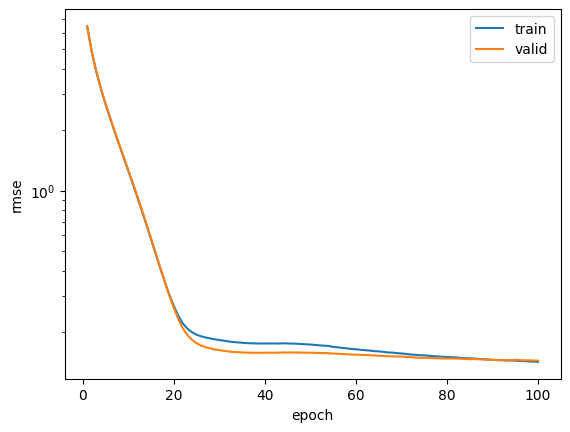

fold 0, train rmse: 0.142321, valid rmse: 0.144386
fold 1, train rmse: 0.137945, valid rmse: 0.152086
fold 2, train rmse: 0.136364, valid rmse: 0.145291
fold 3, train rmse: 0.141257, valid rmse: 0.140900
fold 4, train rmse: 0.133867, valid rmse: 0.169529
5-fold validation: avg train rmse: 0.138351, avg valid rmse: 0.150439


In [32]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0.01, 32
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))


##  **4. Predict and Submit**

Prior to this final configurations, a simple one-layer fully connected or linear neural network was tested. The current configuration uses MLP with 1 hidden layer. However, there is little difference between the two models. This is because the data itself is not very complex and a simple linear model already does an adequate job. In this case, adding more complexity to the model does not necessarily improve the results.

Nevertheless, the MLP configuration is still chosen as it is still better, even at a negligible rate. Screenshot of the kaggle score is provided at the bottom.

Convolutional neural networks (CNNs) and recurrent neural networks (RNNs) have been considered but ultimately not chosen as CNN is tailored for image data and RNN are more fitted towards sequential data like time.

In [35]:
# To write .csv file for kaggle submission
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    plt.plot(list(range(1, num_epochs + 1)), train_ls)
    plt.xlabel('epoch')
    plt.ylabel('rmse')
    plt.legend(['train', 'valid'])
    plt.yscale('log')
    plt.show()
    print(f'Training loss：{float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    #submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    #submission.to_csv('/content/drive/My Drive/ICT303A1/submission.csv', index=False)

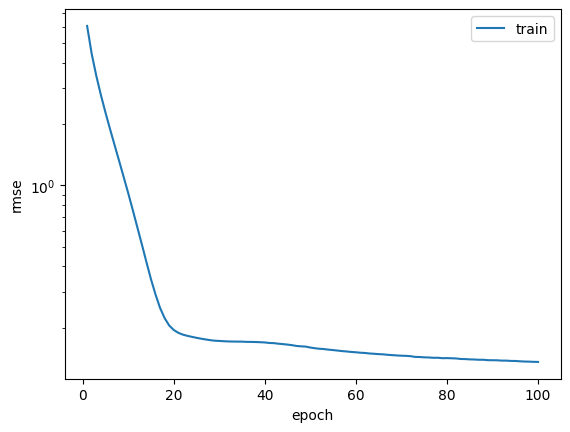

Training loss：0.135894


In [37]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)